# Speed control in biological sequence-generating network

Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.


## Network architecture

The network is currently a feed-forward chain of excitatory ensembles, a very paired down model of HVC. Each excitatory ensemble is a recurrently connected group of excitatory neurons, and each ensemble projects with a set of feed-forward connections to the next ensemble in the chain. The entire chain is subject to time-varying inhibitory inputs (a very pared down model of inputs from Uva), where inhibition is provided as stochastic synaptic inputs to the excitatory neurons, uniform across all neurons and independent to each neuron.

## Utility of the current model

The main utility of the current model is that the speed at which the spike pulse propagates along the chian can be controlled by the level of inhibitory input to the chain. Roughly, within a certain range, the more inhibitory input you provide, the slower the spike pulse propagates, since it takes longer for each neuron's voltage to reach threshold. This is shown below.

## Limitations of current model

The model demonstrates proof-of-principle but is not as biological as it should be. Ideally we'd like to overcome the following limitations:

1. Each excitatory cell spikes only once and is then held silent for a long refractory period. Ideally we want each excitatory cell to have realistic refractory periods (~2ms) and to burst spike with about ~5-6 spikes over 10 ms during the sequence.

2. There is no inhibitory population of neurons. Ideally we want the excitatory chain to be reciprocally connected to an inhibitory population of neurons. This should have the effect of capping the total number of excitatory neurons that spike. I.e. excess spiking in the excitatory chain triggers increased inhibition which shuts down excess spiking but without shutting down the sequence propagation (i.e. it stabilizes the sequence propagation to have about the same firing rate through the sequence.)

3. Together these cause the uninhibited chain's spike pulse to propagate quite quickly, although it can be slowed by inhibition. Thus, many chain links are required for a long sequence. However, it is likely that by incorporating (1) and (2) the baseline spike pulse may move much slower, such that fewer chain links are required for a longer sequence.

## Next steps

The main goal is to make the existing model at least slightly more biological. The more the E/I spiking dynamics of this model resemble Fig 2b from [Hahnloser, Kozhevnikov, and Fee (Nature 2002)](https://www.nature.com/articles/nature00974), the better. The trick is making this happen while maintaining the ability to control, via global input to the network, the speed at which the spike pulse propagates.

As per the above section, there are a couple ways of going about this.

1. Make neurons burst instead of spiking only once. To do this, decrease the excitatory refractory period to something more realistic, like 2 ms, and increase the excitatory drive to the neurons (probably start w/ the within-link excitation, then maybe increase feed-forward excitation?) while adding adaptation to the neurons such that they shut themselves off after about 5-6 spikes. To add adaptation, introduce an additional inhibitory synapse type 'A', that connects each neuron to itself (i.e. self-synapses). I.e. the more a neuron spikes the more it will inhibit itself, decreasing its ability to spike further. Do this by setting the reversal potential (E_A) for the synapse to around -100 mV and the time constant to something long enough to achieve the desired effect.

2. Add an inhibitory pool of neurons, and then connections from the excitatory chain to the inhibitory pool and from the inhibitory pool back to the excitatory pool. Make all of these global to start with (i.e. each exc neuron projects to all inh neurons, and each inh neuron projects to each exc neuron). Add the E->I cxns first, with the I->E cxns set to zero. Then play with connection strengths to see how strong they need to be for the inh population to activate in response to the exc population. Then add in inh --> exc connections, and play with the connection strength parameters until the spike pulse propagates robustly down the chain, but it is clear that the inhibitory connections are playing a role in controlling the propagation speed.

Note 1: To clarify, at this point you'll have the HVC total population, which has both E and I neurons, and with E->E connections (the chain), E->I connections (global), and I->E connections (global). You'll also have inhibitory input from Uva to the HVC E neurons. (Also, in the code I have a few excitatory inputs to the first chain link, which I use to start the sequence.)

Note 2: At each step of development, you want to make sure you have some control over the speed at which the spike pulse propagates along the chain, when you turn the knob of how much inhibitory Uva input to the HVC E neurons you provide. It will probably be much harder to add everything in and then find a good parameter regime.

At the end of the day, we basically want a few plots of the form shown in [Hahnloser, Kozhevnikov, and Fee (Nature 2002)](https://www.nature.com/articles/nature00974) Fig 2b, where each one shows the propagation under a different level of inhibitory input from Uva. The more that the Uva inhibitory input can decrease the speed, but without destroying the propagation of the spike pulse, the better. I.e. if you can slow down the spike pulse propagation speed by a factor of ~2, but where the HVC E neurons still burst with about 5-6 spikes over 10 ms, that would be super ideal.

Note 3: Another good plot, once you have a reasonable set of parameters, would be to show the range of Uva-inspired inhibitory inputs to the chain that allow sequence propagation (probably zero to some upper limit), and then sequence propagation speed as a function of inhibitory input frequency. Based on previous simulations I ran, you might expect to see a threshold-like change in propagation speed once the inhibitory inputs pass a certain frequency, and then for the sequence to fail to propagate once they exceed an even higher frequency.

# Existing model

Extend this model to make it more biological. (Make sure to do so incrementally, i.e. making sure it at least sort of works each step of the way; otherwise it will be much harder to find viable parameter regimes.)

## Parameters

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [11]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
import datetime
import os

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

from utils.general import *
from utils.file_io import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=1.6e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.05e-3,  # I->E input weights
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)
S.T = 0.3

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

N_P_I = 30         # numpber in pool of inhibitory neurons

# ntwk params
m = copy(M)
m.N_E = m.N_L*m.N_L_E  # total number of E nrns
m.N_N = m.N_E + N_P_I

T_M_E = 10.0 ms


# Full chain

## Speed control via INH input

In [12]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

def last_spk_tm(tms_p_link):
    l = len(tms_p_link)
    for i in range(l):
        tms_for_link = tms_p_link[l - i - 1]
        if len(tms_for_link) > 0:
            return tms_for_link[-1]

In [17]:
def load_batch(data_path, batch_name):
    fs = [f for f in sorted(all_files_with_name_frags(data_path, batch_name))]
    for f_idx, f in enumerate(fs):
        batch_data = pickle.load(open(os.path.join(data_path, f), 'rb'))
        yield batch_data

In [57]:
w_e_i_r_range = np.linspace(0.002e-3, 0.01e-3, 8)
w_i_e_r_range = np.linspace(0.002e-3, 0.01e-3, 8)
w_e_e_r_range = np.linspace(0.005e-3, 0.015e-3, 8)
w_e_e_f_range = np.linspace(0.005e-3, 0.015e-3, 8)
uva_range = np.linspace(0.5, 1.5, 3)

params = param_range_gen(w_e_i_r_range, w_i_e_r_range, w_e_e_r_range, w_e_e_f_range, uva_range)

def scan_batch(batch_results, batch_params):
    good_results = []
    x = np.arange(m.N_L) + 1

    for r_idx, r in enumerate(zip(batch_results, batch_params)):
        (res, p) = r

        keep = True
        results = []
        last_inv_slope = None
        slp_diff_thrsh = 50

        for frq_idx, frq_res in enumerate(res):

            tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
            mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
            std_tms_p_link = np.array([np.std(tms_for_link) for tms_for_link in tms_p_link])

            mean_of_std = np.mean(std_tms_p_link[~np.isnan(std_tms_p_link)])
            std_of_std = np.std(std_tms_p_link[~np.isnan(std_tms_p_link)])

            counts_per_link = np.array(map_to_list(lambda l: l.size, tms_p_link))
            mean_cnts_p_link = np.mean(counts_per_link[counts_per_link > 0])
            std_cnts_p_link = np.std(counts_per_link[counts_per_link > 0])

            if ((len(tms_p_link[-1]) == 0 and (last_spk_tm(tms_p_link) < (.3 - 0.01)))
                or std_of_std / mean_of_std > 0.3 or std_cnts_p_link / mean_cnts_p_link > 0.3
                or mean_cnts_p_link > 6 * m.N_L_E or mean_cnts_p_link < 4 * m.N_L_E):
                keep = False
                break
            else:
                slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]
#                 inv_slp = 1./slp
#                 if last_inv_slope is not None:
#                     if last_inv_slope - inv_slp < slp_diff_thrsh:
#                         keep = False
#                         break
#                 last_inv_slope = inv_slp
                results.append([mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link])
        if keep:
            print('added')
            good_results.append((r_idx, p, results))

    for idx, p, r in good_results:
        print(idx, p)
        for frq_idx, frq_res in enumerate(r):
            (mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link) = frq_res
            print(1./slp)
            gs = gridspec.GridSpec(2, 1)
            fig = plt.figure(figsize=(10, 10), tight_layout=True)
            axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
            axs[0].set_title(f'index: {idx} freq: {frq_idx * 400} params:' + ' '.join(map_to_list(lambda p_i: f'{p_i}', p)))
            axs[0].fill_between(x, mean_tms_p_link - std_tms_p_link, mean_tms_p_link + std_tms_p_link, color='red', alpha=0.25)
            axs[0].scatter(x, mean_tms_p_link, s=3, c='red')
            axs[0].set_ylim(0, 0.3)
            axs[0].set_xlim(0, m.N_L)

            for l_cntr in range(m.N_L):
                y = l_cntr * np.ones(len(tms_p_link[l_cntr])) + 1
                axs[1].scatter(tms_p_link[l_cntr], y + .2 * np.random.randn(len(y)), s=5, c='black', zorder=0)
                axs[1].set_ylim(0, m.N_L)

added
26 [2.00000000e-06 6.57142857e-06 7.85714286e-06 9.28571429e-06
 1.00000000e+00]
345.7687259772903
329.4446219810925
302.34293826510907
added
78 [2.00000000e-06 7.71428571e-06 5.00000000e-06 1.35714286e-05
 5.00000000e-01]
548.3179132815538
515.3573318527539
502.64872419558753
added
added
73 [2.00000000e-06 8.85714286e-06 5.00000000e-06 1.50000000e-05
 5.00000000e-01]
639.4625467910731
584.6777853550462
611.5601528925157
91 [2.00000000e-06 8.85714286e-06 6.42857143e-06 1.21428571e-05
 5.00000000e-01]
407.68958997663543
410.9455340153393
393.7989176358038
added
added
65 [2.0e-06 1.0e-05 5.0e-06 1.5e-05 5.0e-01]
614.7910572712398
563.7641064757335
525.5526388341573
86 [2.00000000e-06 1.00000000e-05 6.42857143e-06 1.35714286e-05
 5.00000000e-01]
414.78679134675906
416.92436740296387
408.6899187076035
added
added
added
added
7 [2.00000000e-06 1.00000000e-05 7.85714286e-06 1.21428571e-05
 5.00000000e-01]
371.62224004850333
380.13705168244746
370.9325836546969
8 [2.00000000e-06 1.00000

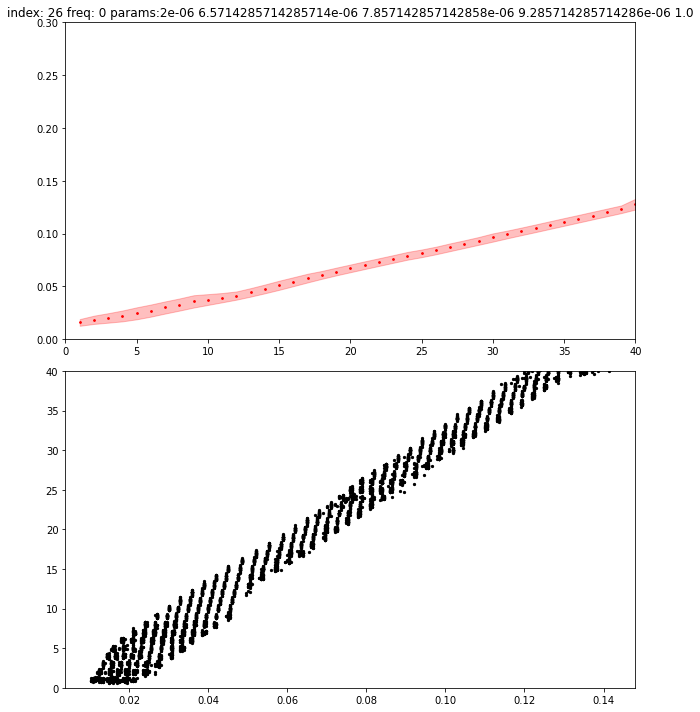

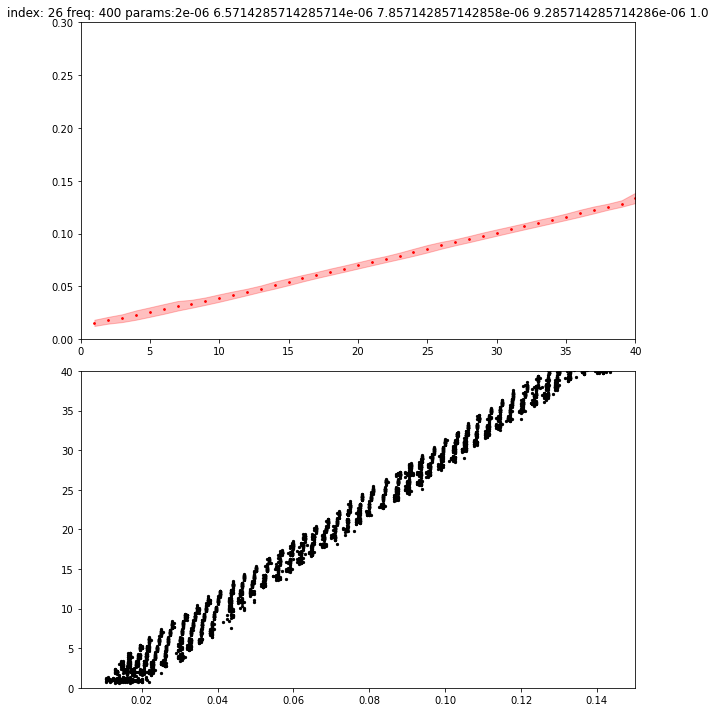

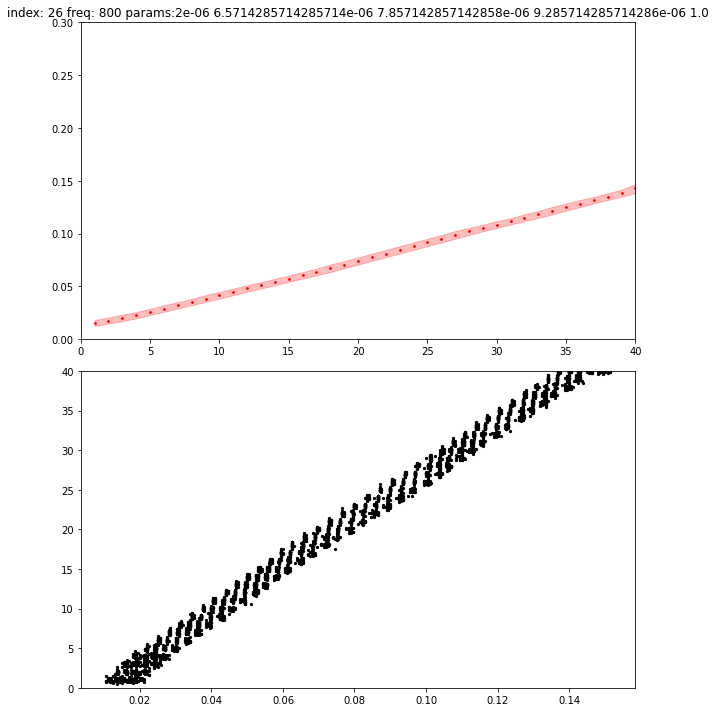

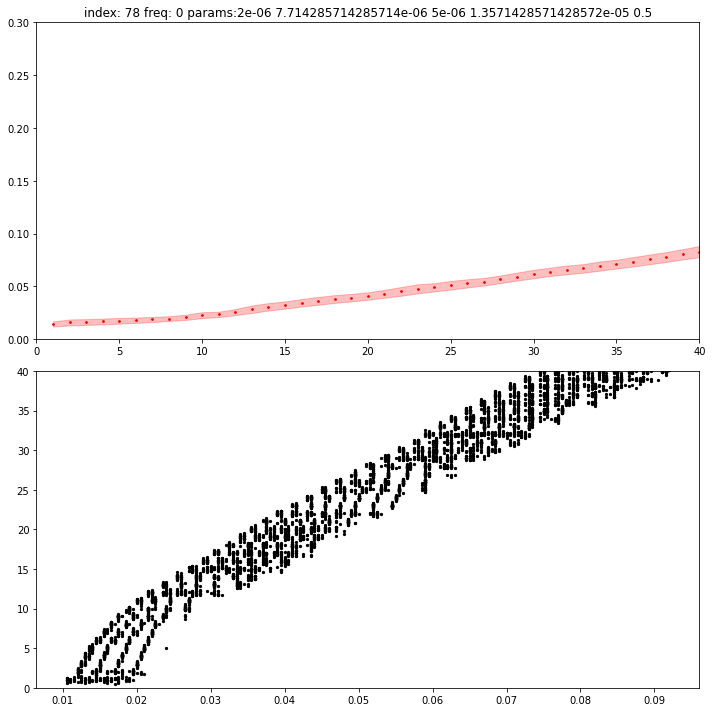

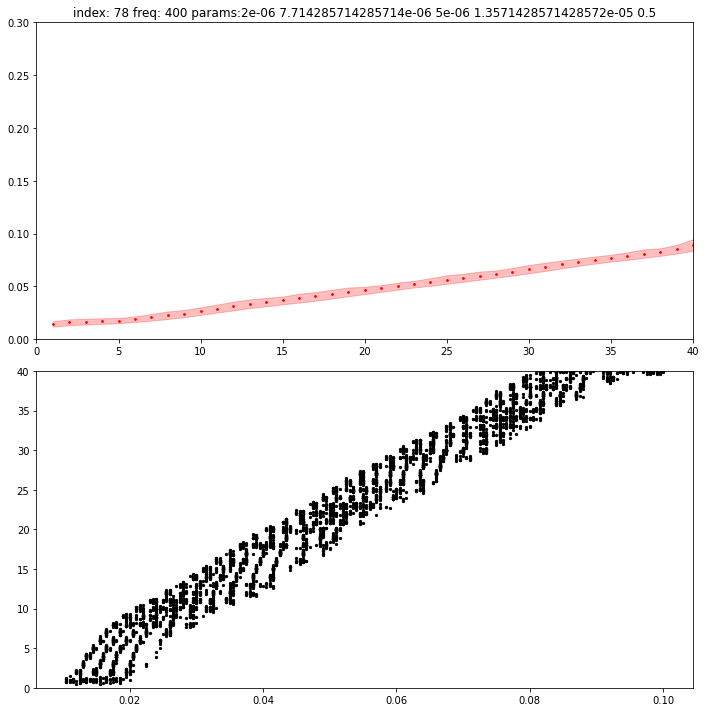

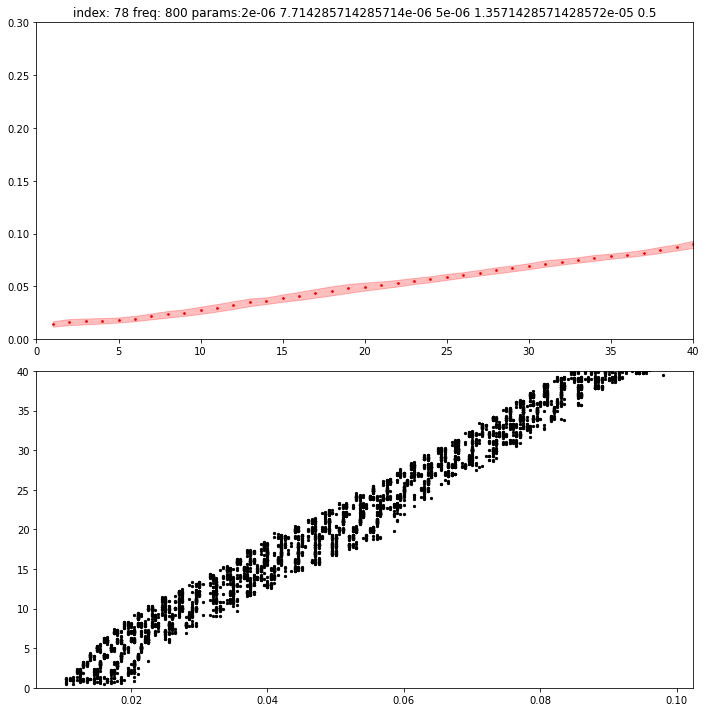

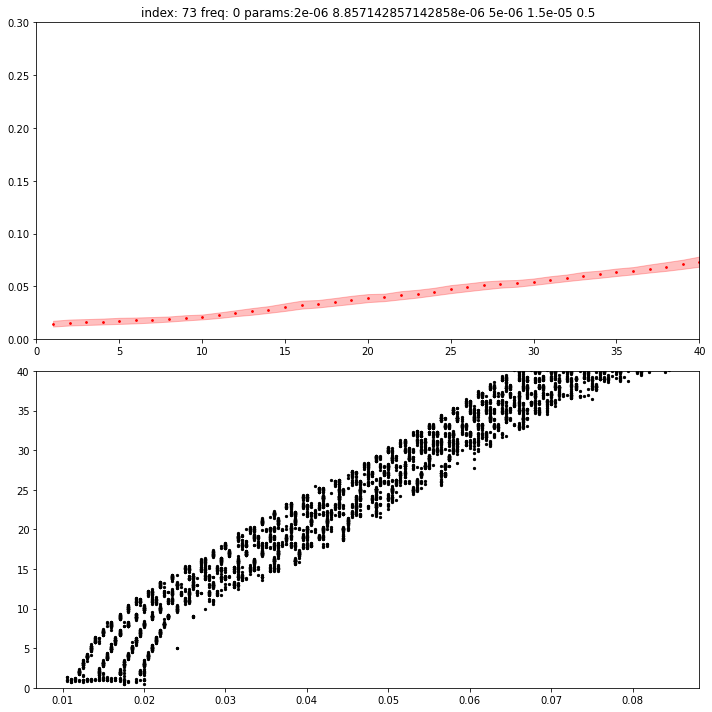

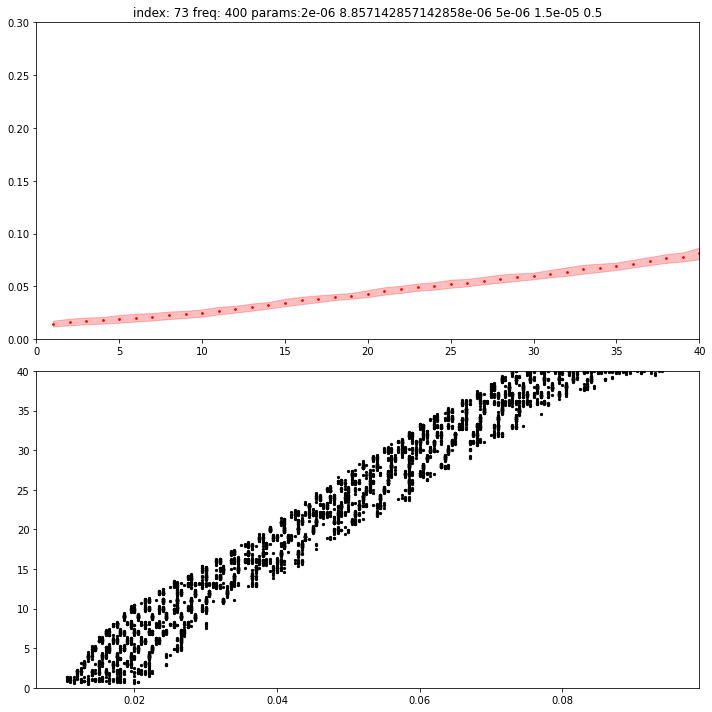

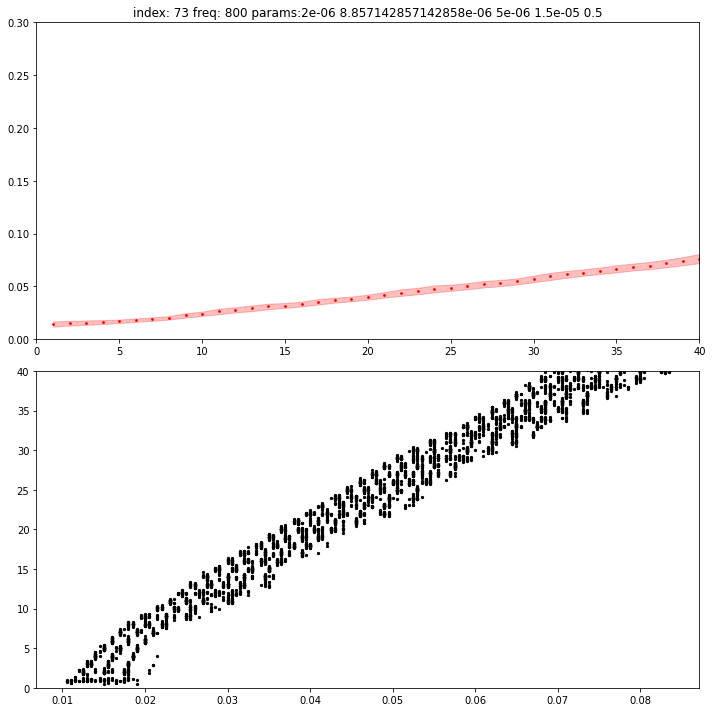

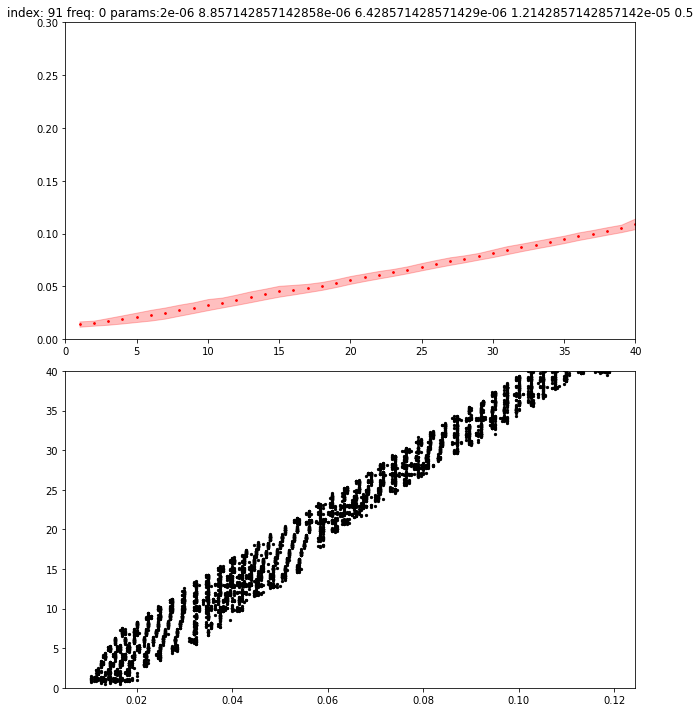

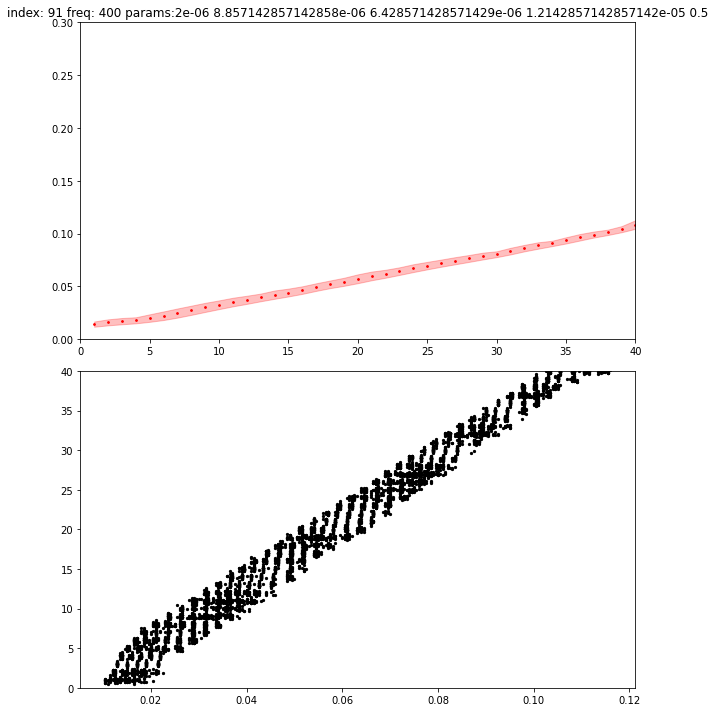

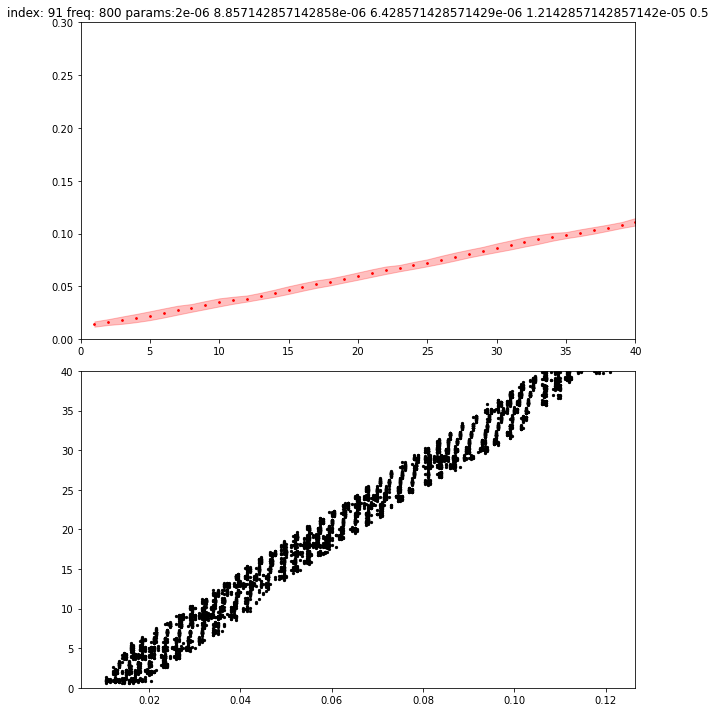

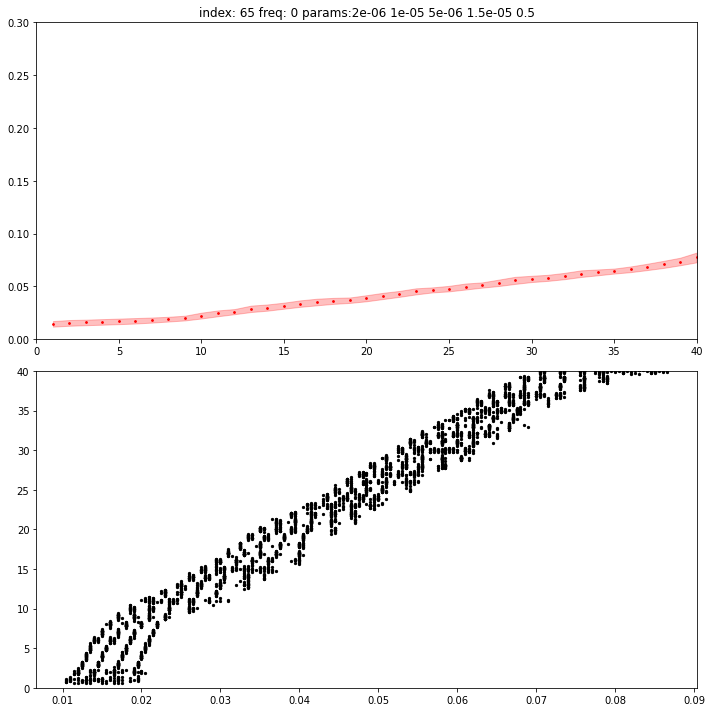

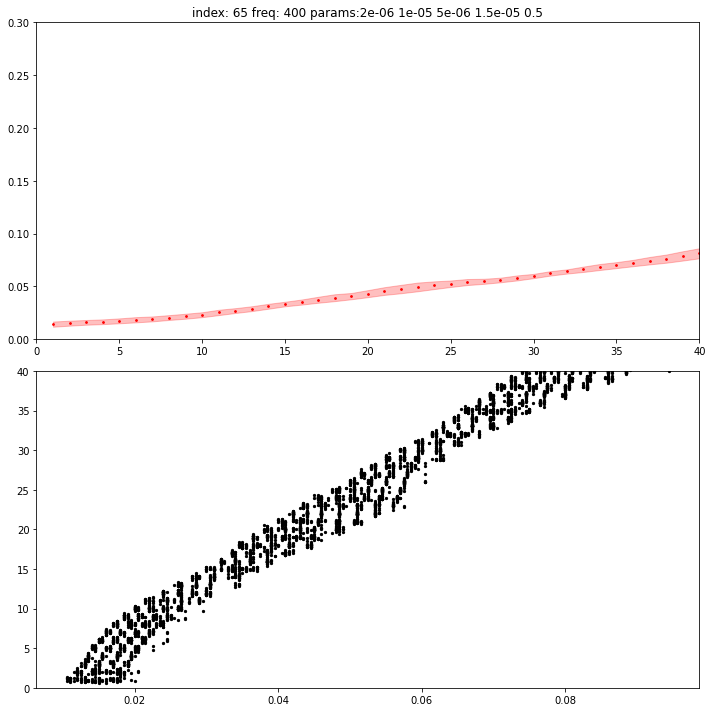

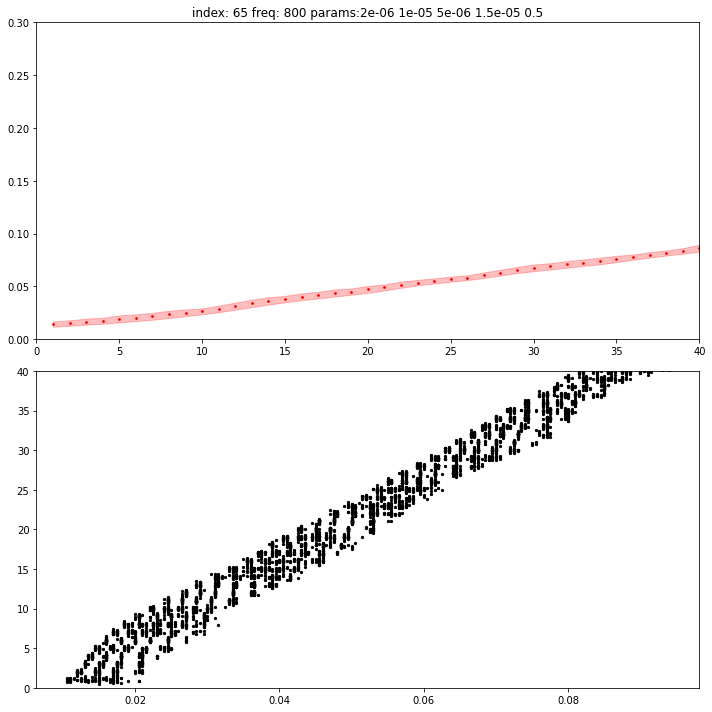

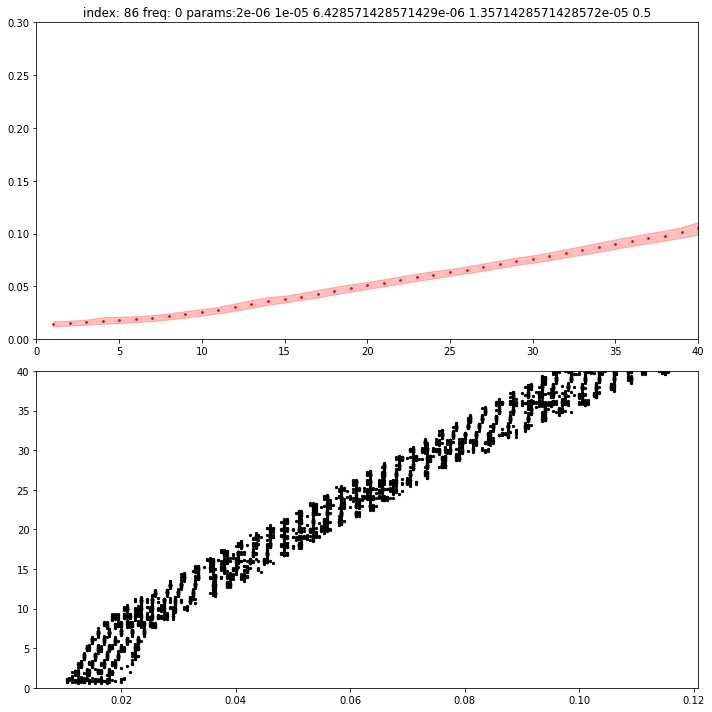

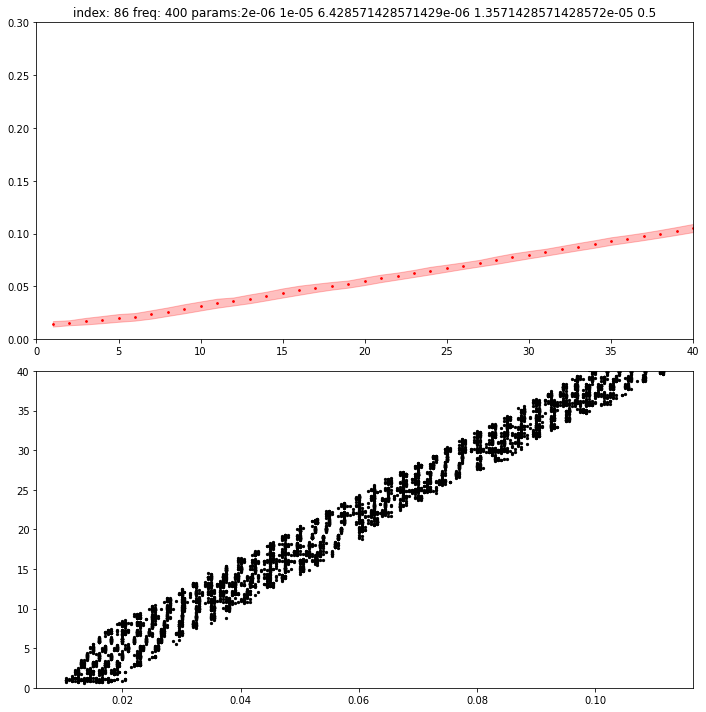

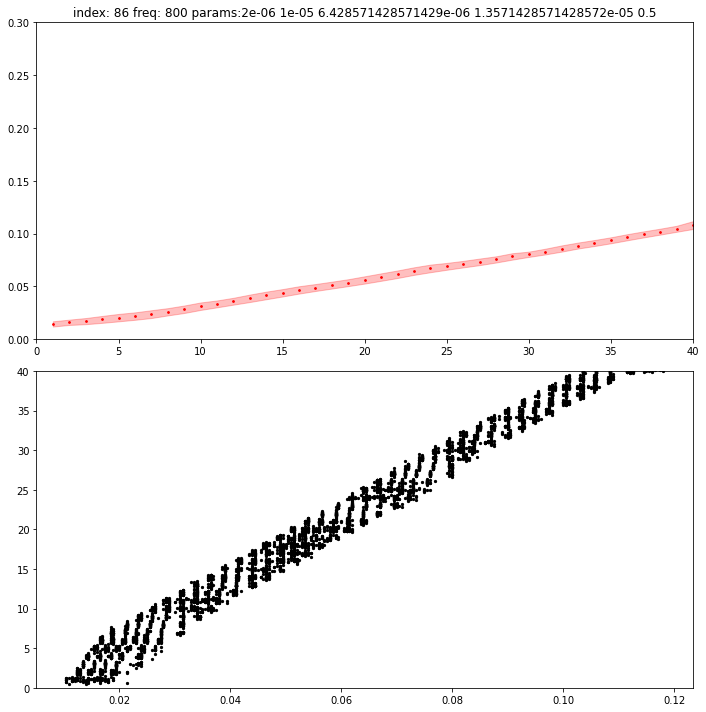

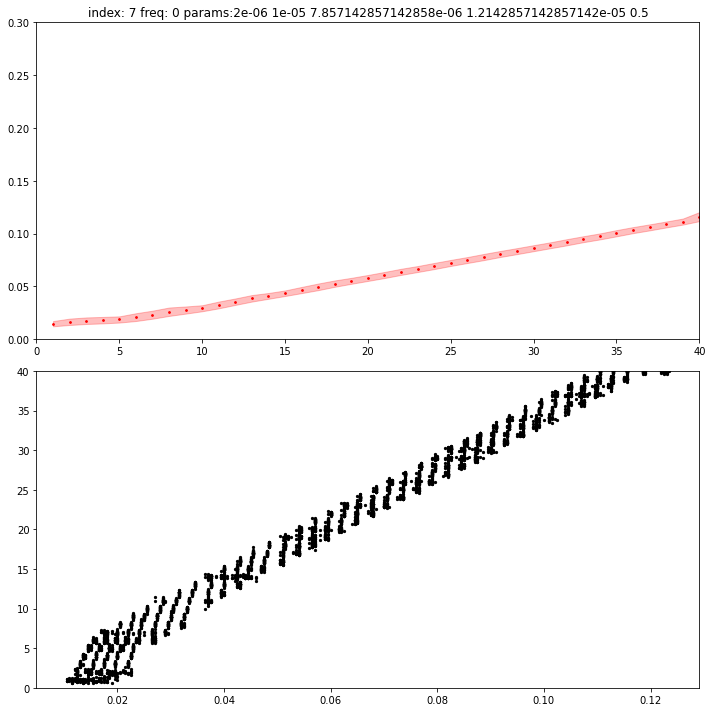

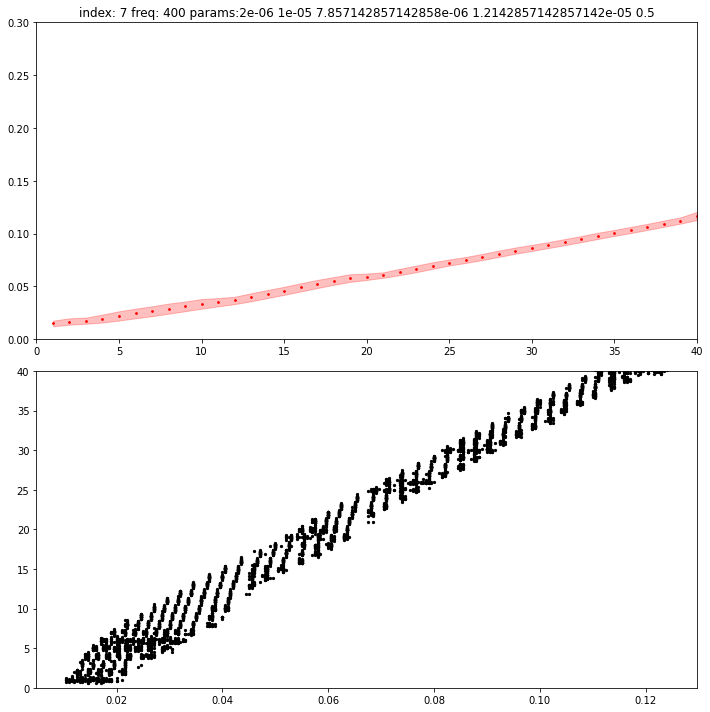

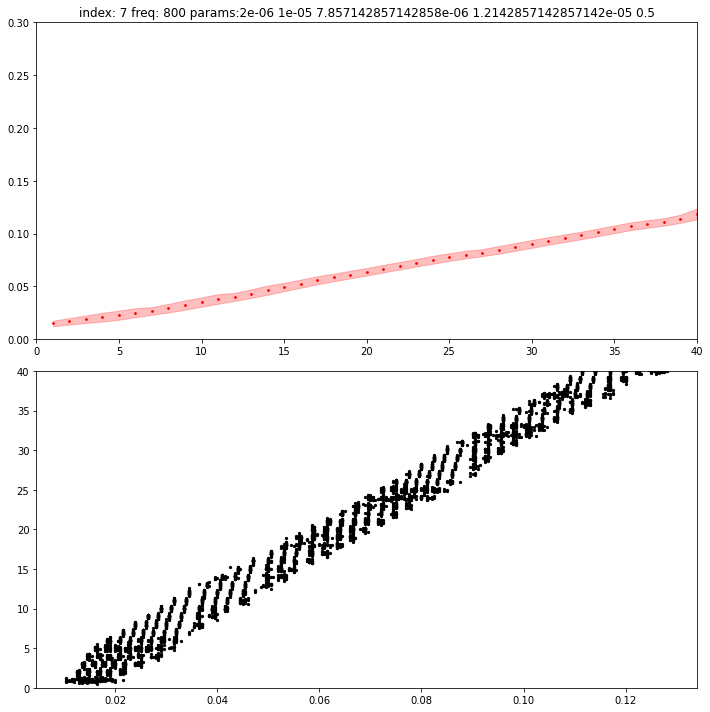

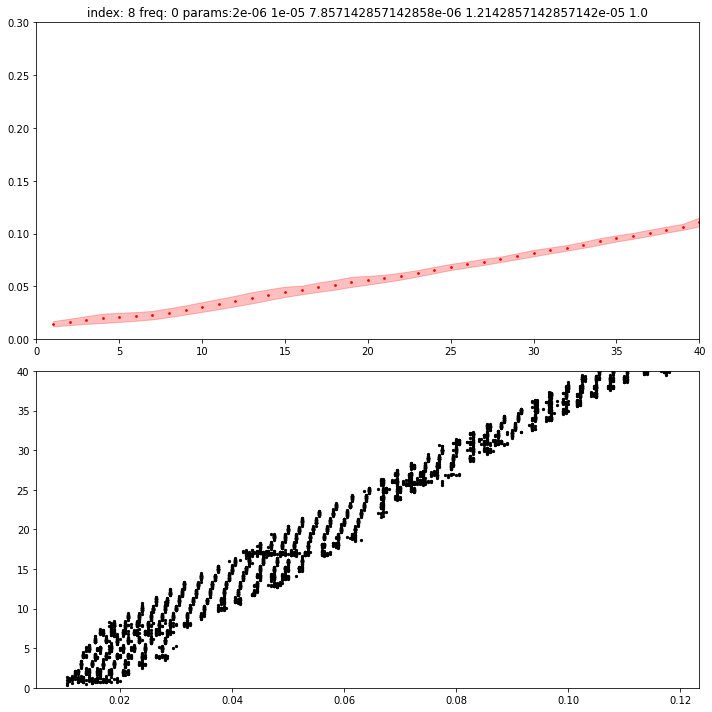

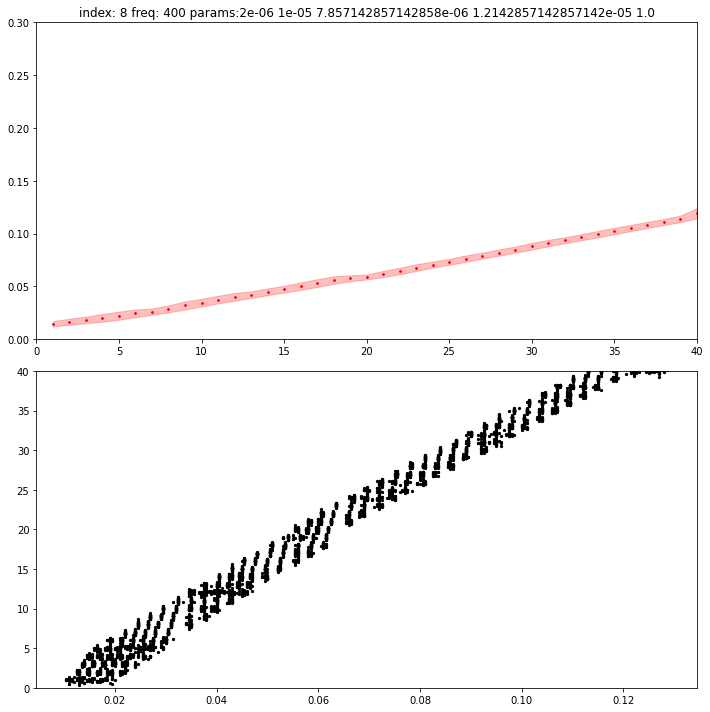

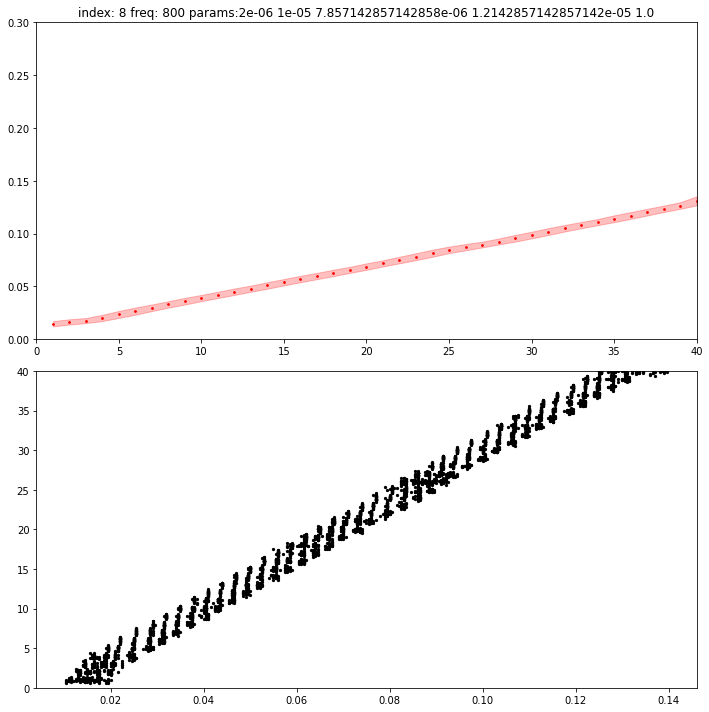

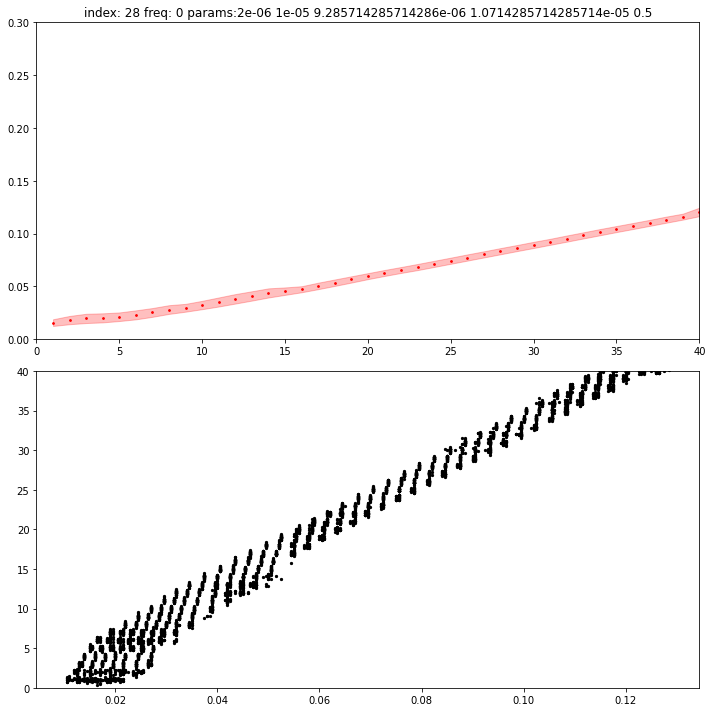

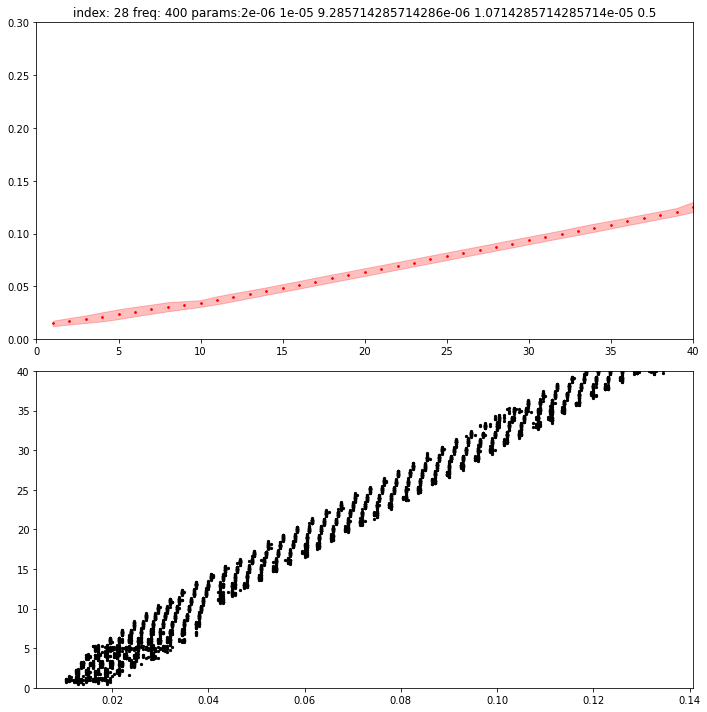

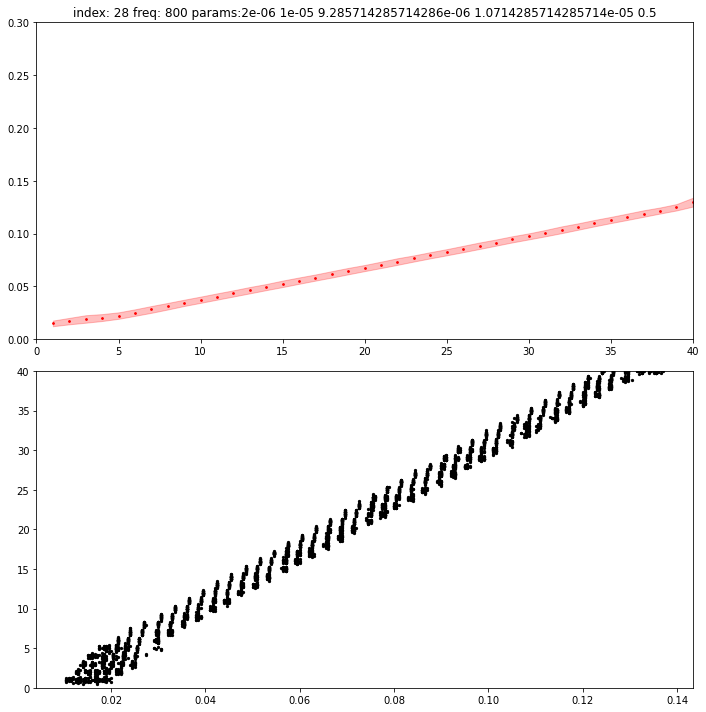

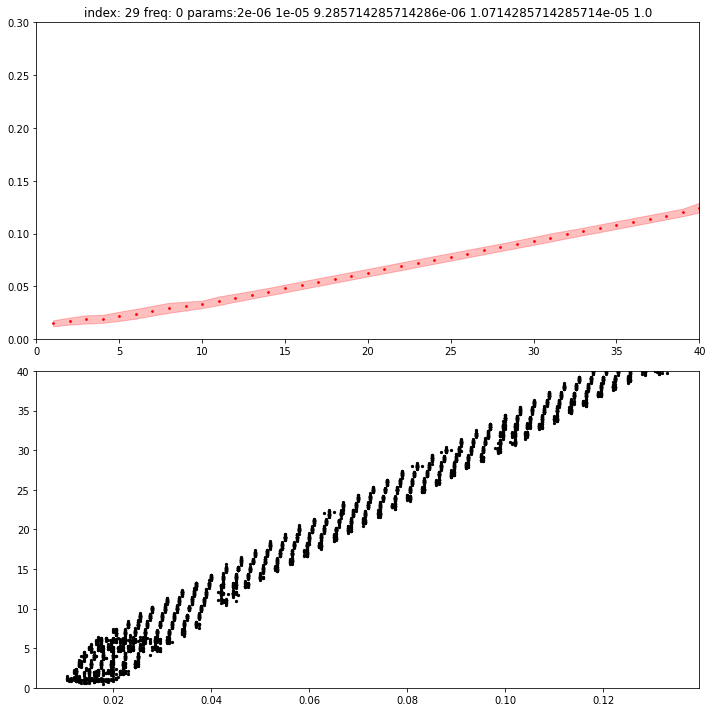

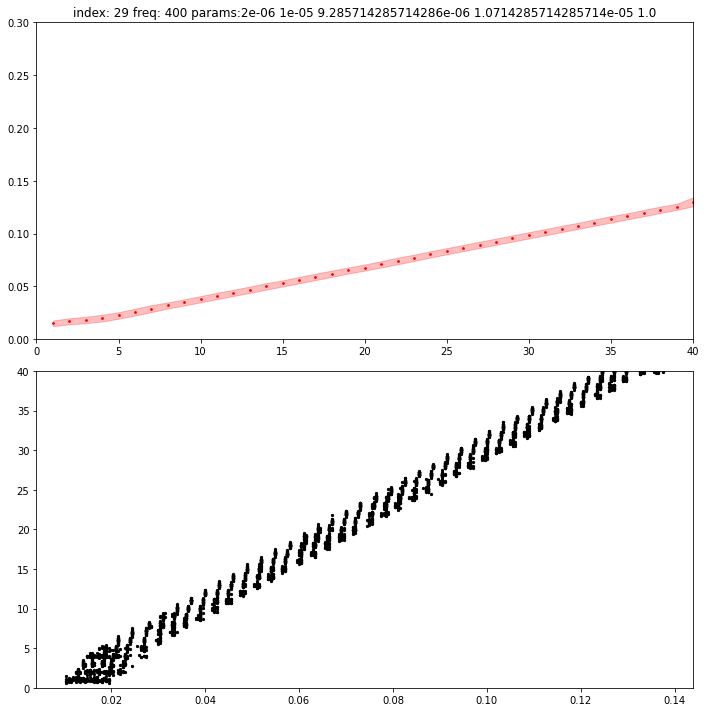

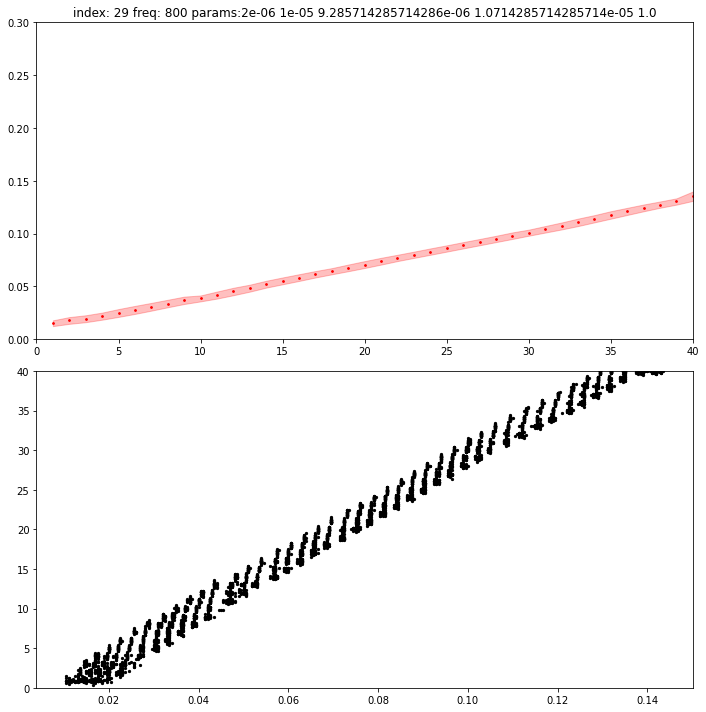

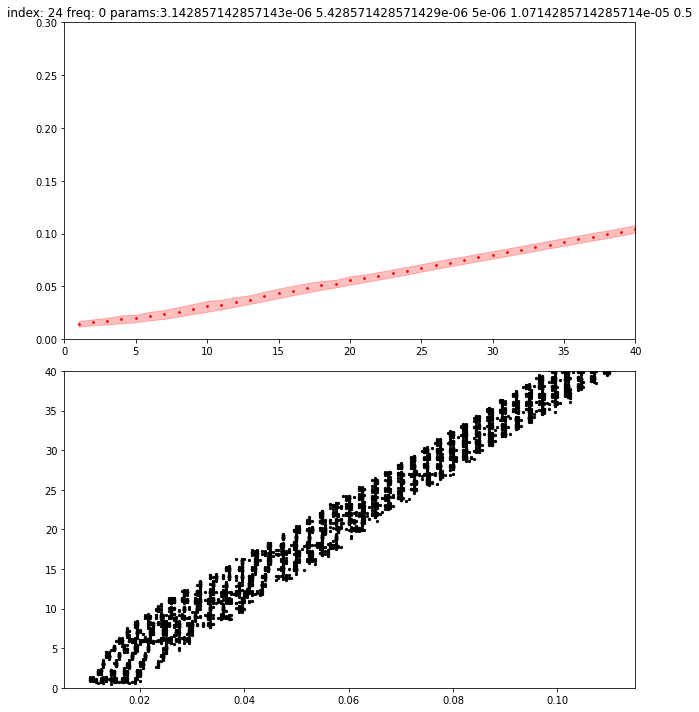

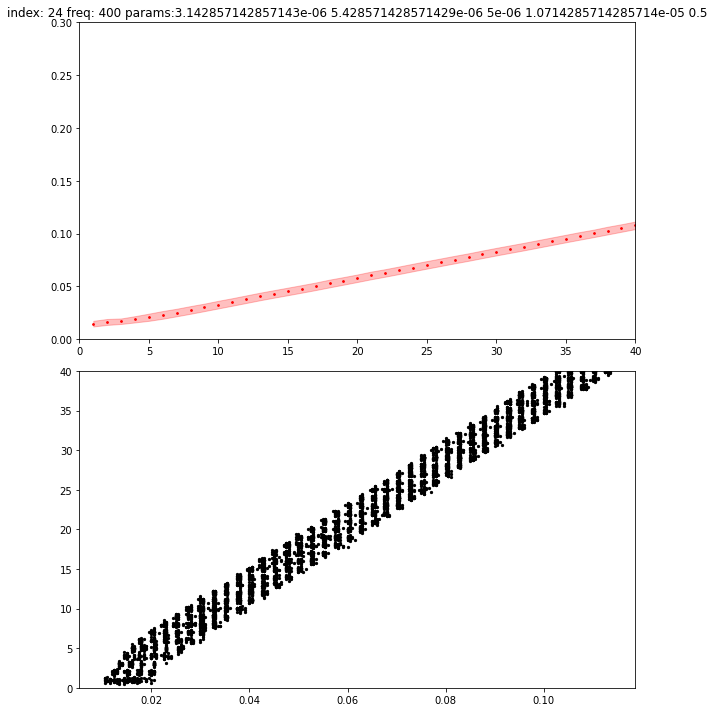

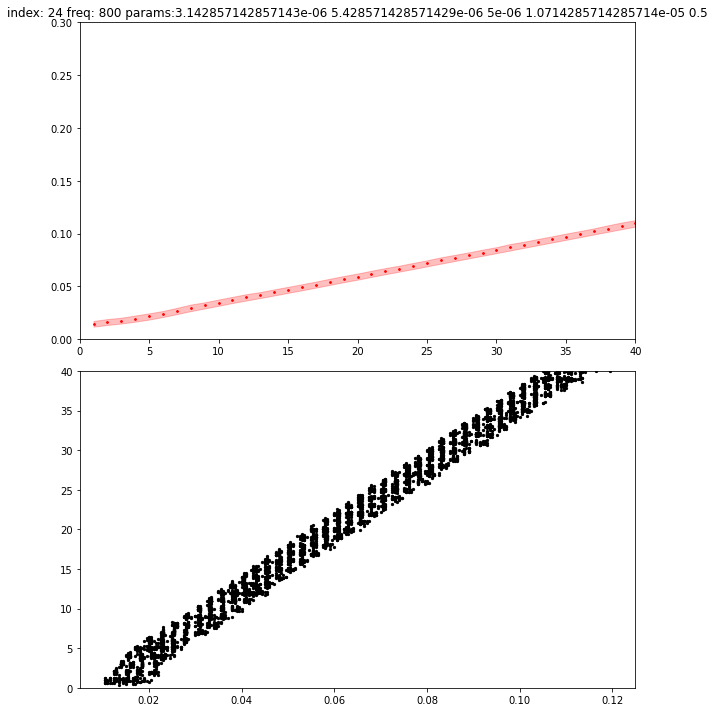

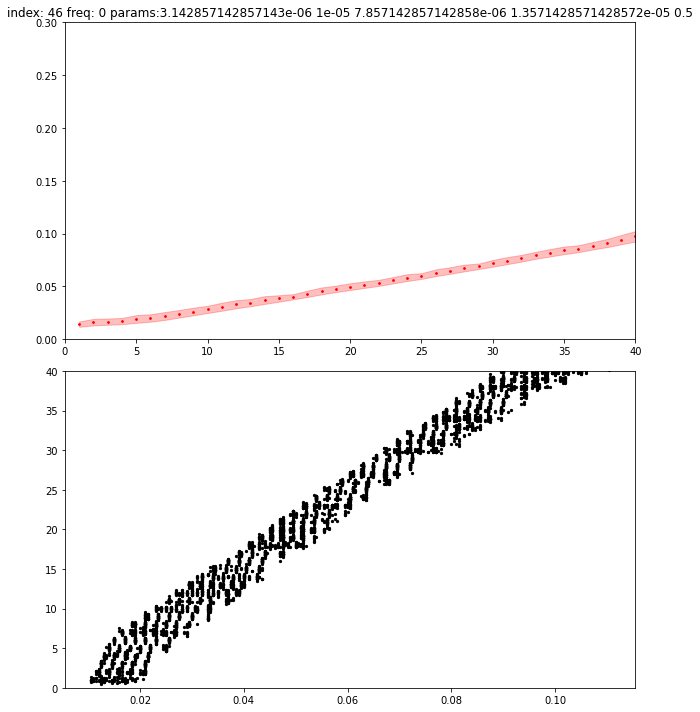

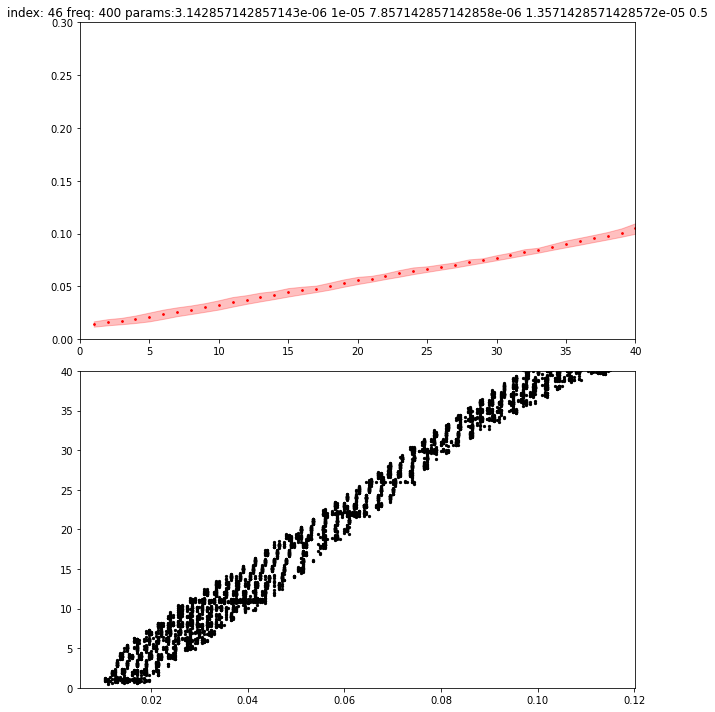

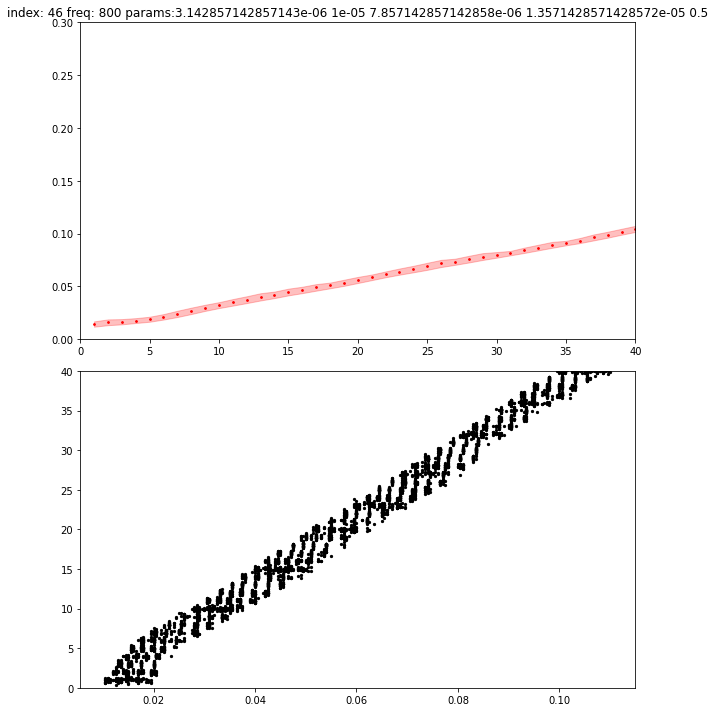

In [58]:
batch_size = 100

for batch_idx, batch_data in enumerate(load_batch('./data', 'exp_batch_2020-05-11--00:02')):
    batch_start = batch_idx * batch_size
    batch_end = np.min([batch_start + batch_size, len(params)])
    scan_batch(batch_data, params[batch_start:batch_end])

In [ ]:
#     # plot results (spks and voltage for each chain link)
#     c = get_spaced_colors('hsv', m.N_L, 75/256)
#     v_space = 1.5 * (m.V_TH_E - m.E_I)

#     gs = gridspec.GridSpec(4, 1)
#     fig = plt.figure(figsize=(15, 15), tight_layout=True)
#     axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2:])]

#     y_tick = []

#     t_spk_all = []
#     x_spk_all = []

#     for l_ctr in range(m.N_L):
#         # spks & voltages for this link
#         idx_start = l_ctr * m.N_L_E
#         idx_end = (l_ctr+1) * m.N_L_E

#         # raster
#         t_spk, c_spk = rsp.spks[:, idx_start:idx_end].nonzero()
#         t_spk = t_spk*S.DT
#         c_spk = c_spk + idx_start

#         # convert to chain link position
#         x_spk = ntwk.x[c_spk]

#         axs[0].scatter(1000*t_spk, x_spk + .2 * np.random.randn(len(x_spk)), s=5, c=[c[l_ctr]], zorder=0)

#         # voltages
#         if l_ctr < L_MAX_V:
#             axs[2].plot(1000*t, 1000*(l_ctr*v_space + rsp.vs[:, idx_start:idx_end]), c=c[l_ctr], lw=.5)
#             axs[2].axhline(1000*(l_ctr*v_space + m.E_L_E), c='gray', ls='--', lw=.5)
#             axs[2].axhline(1000*(l_ctr*v_space + m.V_TH_E), c='r', ls='--', lw=.5)

#             y_tick.append(1000 * (l_ctr*v_space + (m.E_L_E + m.V_TH_E)/2))

#         t_spk_all.extend(list(t_spk))
#         x_spk_all.extend(list(x_spk))

#     title = 'Raster\nFQ_SPK_U_I = {} Hz'.format(fq_spk_u_i)

#     # fit/plot line
#     if len(t_spk_all) >= 2:
#         slp, icpt = stats.linregress(t_spk_all, x_spk_all)[:2]
#         t_line = np.array([np.min(t_spk_all), np.max(t_spk_all)])
#         x_line = slp*t_line + icpt
#         axs[0].plot(1000*t_line, x_line, lw=1, c='gray', zorder=1)

#         title += '\n Speed: {0:.1f} links/sec'.format(slp)

#     axs[0].set_ylim(-1, m.N_L)
#     axs[0].set_ylabel('Link position')
#     axs[0].set_title(title)

#     i_t_spk, i_c_spk = rsp.spks[:, (-N_P_I):].nonzero()
#     i_t_spk = i_t_spk * S.DT
#     i_c_spk = i_c_spk

#     axs[1].scatter(1000 * i_t_spk, i_c_spk, c='red', s=2)

#     axs[1].set_ylim(-1, N_P_I)
#     axs[1].set_ylabel('I spikes')
#     axs[1].set_title('Raster of Inhibition')

#     axs[2].set_yticks(y_tick)
#     axs[2].set_yticklabels(np.arange(m.N_L))
#     axs[2].set_ylabel('Chain link number')
#     axs[2].set_title('Membrane voltage (FQ_SPK_U_I = {} Hz)'.format(fq_spk_u_i))

#     for ax in axs:
#         ax.set_xlim(1000*t.min(), 1000*t.max())
#         ax.set_xlabel('Time (ms)')
#         set_font_size(ax, 16)

## Overlay

In [ ]:
c = ['g', 'k', 'r']

fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)

for rsp, fq_spk_u_i, c_ in zip(rsps, FQ_SPK_U_I, c):

    y_tick = []
    
    t_spk_all = []
    x_spk_all = []

    for l_ctr in range(m.N_L):
        # spks & voltages for this link
        idx_start = l_ctr * m.N_L_E
        idx_end = (l_ctr+1) * m.N_L_E

        # raster
        t_spk, c_spk = rsp.spks[:, idx_start:idx_end].nonzero()
        t_spk = t_spk*S.DT
        c_spk = c_spk + idx_start
        
        # convert to chain link position
        x_spk = ntwk.x[c_spk]

        ax.scatter(1000*t_spk, x_spk + .2 * np.random.randn(len(x_spk)), s=3, c=c_, zorder=0)
        
        t_spk_all.extend(list(t_spk))
        x_spk_all.extend(list(x_spk))

ax.set_xlim(10, 90)
ax.set_xticks([10, 30, 50, 70, 90, 110, 130, 150, 170])
ax.set_xticklabels([0, 20, 40, 60, 80, 100, 120, 140, 160])
ax.set_ylim(-1, m.N_L)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
ax.set_ylabel('Link position')

ax.set_xlabel('Time (ms)')
set_font_size(ax, 20)

INH input freq for green, black, red (Hz):

In [ ]:
FQ_SPK_U_I